In [1]:
import os
os.chdir('../..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression
from collections import Iterable
import random
from os import listdir
from os.path import isfile, join
import matplotlib.patches as mpatches


import scipy.stats as st

import seaborn as sns
sns.set_style("whitegrid")

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

D:\Users\glede\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  


# Calculations for stats and plots are based on: https://github.com/stasmix/popsynth/blob/master/pop-synth-vae.ipynb

In [3]:
only_cat = False

# Load the files

In [4]:
dataset = 'LPMC'

In [5]:
synth_dir = '../synth_data/' + dataset

files = ['../data/' + dataset + '/data.csv']
labels = ['original']

for f in listdir(synth_dir):
    if isfile(join(synth_dir, f)):
        files.append(join(synth_dir, f))
        labels.append(f.split('.')[0])

In [6]:
labels

['original',
 'CTGAN',
 'SGAN_OR_BO',
 'SGAN_OR_NO',
 'SGAN_OR_OD',
 'SGAN_WI_BO',
 'SGAN_WI_NO',
 'SGAN_WI_OD',
 'SGAN_WO_BO',
 'SGAN_WO_NO',
 'SGAN_WO_OD',
 'TGAN',
 'WGAN2_WI_BO',
 'WGAN2_WI_NO',
 'WGAN2_WI_OD',
 'WGAN_OR_BO',
 'WGAN_OR_NO',
 'WGAN_OR_OD',
 'WGAN_WI_BO',
 'WGAN_WI_NO',
 'WGAN_WI_OD',
 'WGAN_WO_BO',
 'WGAN_WO_NO',
 'WGAN_WO_OD',
 'WGGP_OR_BO',
 'WGGP_OR_NO',
 'WGGP_OR_OD',
 'WGGP_WI_BO',
 'WGGP_WI_NO',
 'WGGP_WI_OD',
 'WGGP_WO_BO',
 'WGGP_WO_NO',
 'WGGP_WO_OD']

In [7]:
if dataset is 'Chicago':
    continuous_cols = ['distance', 'age', 'departure_time']
elif dataset is 'LPMC':
    continuous_cols = ['start_time_linear', 'age', 'distance', 'dur_walking', 'dur_cycling', 'dur_pt_access', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int', 'dur_driving', 'cost_transit', 'cost_driving_fuel', 'driving_traffic_percent']

In [8]:
dfs = [pd.read_csv(file) for file in files]

In [9]:
#for i in range(len(dfs)):
#    dfs[i] = dfs[i].drop(['dur_pt_rail', 'dur_pt_int'], axis=1)

In [10]:
if only_cat:
    print("REMOVING CONT")
    for i in range(len(dfs)):
        dfs[i] = dfs[i].drop(continuous_cols, axis=1)

# Transform all values in numerical

In [11]:
dfs[0].dtypes

travel_mode                 object
purpose                     object
fueltype                    object
faretype                    object
bus_scale                  float64
survey_year                  int64
travel_year                  int64
travel_month                 int64
travel_date                  int64
day_of_week                  int64
start_time_linear          float64
age                          int64
female                       int64
driving_license              int64
car_ownership                int64
distance                     int64
dur_walking                float64
dur_cycling                float64
dur_pt_access              float64
dur_pt_rail                float64
dur_pt_bus                 float64
dur_pt_int                 float64
pt_n_interchanges            int64
dur_driving                float64
cost_transit               float64
cost_driving_fuel          float64
cost_driving_con_charge    float64
driving_traffic_percent    float64
dtype: object

In [12]:
if dataset is 'Chicago':
    ints = ['travel_dow', 'hh_vehicles', 'hh_size', 'hh_bikes', 'hh_income', 'gender', 'education_level', 'age']
    floats = ['departure_time', 'distance']
    strs = ['choice', 'trip_purpose', 'work_status', 'hh_descr']
elif dataset is 'LPMC':
    ints = ['survey_year', 'travel_year', 'travel_month', 'travel_date', 'day_of_week', 'age', 'female', 'driving_license', 'car_ownership', 'distance', 'pt_n_interchanges']
    floats = ['bus_scale', 'start_time_linear', 'dur_walking', 'dur_cycling', 'dur_pt_access', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int', 'dur_driving', 'cost_transit', 'cost_driving_fuel', 'cost_driving_con_charge', 'driving_traffic_percent']
    #floats = ['bus_scale', 'start_time_linear', 'dur_walking', 'dur_cycling', 'dur_pt_access', 'dur_pt_bus', 'dur_driving', 'cost_transit', 'cost_driving_fuel', 'cost_driving_con_charge', 'driving_traffic_percent']
    strs = ['travel_mode', 'purpose', 'fueltype', 'faretype']

In [13]:
dct = {}

for i in ints:
    dct[i] = 'int64'
    
for i in floats:
    dct[i] = 'float64'

In [14]:
dct

{'survey_year': 'int64',
 'travel_year': 'int64',
 'travel_month': 'int64',
 'travel_date': 'int64',
 'day_of_week': 'int64',
 'age': 'int64',
 'female': 'int64',
 'driving_license': 'int64',
 'car_ownership': 'int64',
 'distance': 'int64',
 'pt_n_interchanges': 'int64',
 'bus_scale': 'float64',
 'start_time_linear': 'float64',
 'dur_walking': 'float64',
 'dur_cycling': 'float64',
 'dur_pt_access': 'float64',
 'dur_pt_rail': 'float64',
 'dur_pt_bus': 'float64',
 'dur_pt_int': 'float64',
 'dur_driving': 'float64',
 'cost_transit': 'float64',
 'cost_driving_fuel': 'float64',
 'cost_driving_con_charge': 'float64',
 'driving_traffic_percent': 'float64'}

In [15]:
if only_cat:
    print("REMOVING CONT")
    for c in continuous_cols:
        dct.pop(c) 

In [16]:
dfs = [df.astype(dct) for df in dfs]

In [17]:
for c in strs: 
    dct = {}
    
    for n, i in enumerate(dfs[0][c].unique()):        
        dct[i] = n
        
    dfs = [df.replace(dct) for df in dfs]

In [18]:
dfs[0].dtypes

travel_mode                  int64
purpose                      int64
fueltype                     int64
faretype                     int64
bus_scale                  float64
survey_year                  int64
travel_year                  int64
travel_month                 int64
travel_date                  int64
day_of_week                  int64
start_time_linear          float64
age                          int64
female                       int64
driving_license              int64
car_ownership                int64
distance                     int64
dur_walking                float64
dur_cycling                float64
dur_pt_access              float64
dur_pt_rail                float64
dur_pt_bus                 float64
dur_pt_int                 float64
pt_n_interchanges            int64
dur_driving                float64
cost_transit               float64
cost_driving_fuel          float64
cost_driving_con_charge    float64
driving_traffic_percent    float64
dtype: object

# Compute the stats

In [19]:
# calculate min_max_bins for an arbitrary discretization scheme
def get_min_max(data1, data2, num_bins, cont_cols):
    """
    Create a dictionnary with all variables indicating the number of bins and the min and max value 
    """
    
    min_max = {}
    eps = 1e-10
    
    # Go through all columns in the first dataset (assuming data2 has the same columns)
    for c in data1.columns:
        if c in cont_cols: # Continuous column
            
            # Compute min and max values between both datasets
            min_val = min(np.min(data1[c]), np.min(data2[c])) - eps
            max_val = max(np.max(data1[c]), np.max(data2[c])) + eps
            
            # Fill the dict
            min_max[c] = [min_val, max_val, num_bins]
            
        else: # Categorical column
            # Set of all unique values in both datasets
            unique_vals = set(np.unique(data1[c])).union(set(np.unique(data2[c])))
                                    
            num_bins_cat = min(len(unique_vals), num_bins)
            
            min_max[c] = [min(unique_vals), max(unique_vals), num_bins_cat]
                

    return min_max

In [20]:
def get_frequency_list(original, synthetic, max_num_bins, cat=True):
    """
    Compute the frequency lists
    """
    
    # Check if the number of unique values is less than the max
    # number of bins for the cat variables
    if cat:
        unique_vals = set(np.unique(original))
        
        if len(unique_vals) > max_num_bins:
            cat = False
    
    eps = 1e-10
    # Compute min and max values between both datasets
    min_val = np.min(original) - eps
    max_val = np.max(original) + eps
    
    # Compute the bins
    bins = []
    if cat:
        # bins = all values
        bins = list(unique_vals)
        bins.sort()
    else:
        # bins = hist bins
        delta = (max_val-min_val)/max_num_bins
        for i in range(max_num_bins+1):
            bins.append(min_val+delta*i)
            
    # Calculate the frequencies
    freqs = []
    if cat:
        count_orig = [(original==b).sum() for b in bins]
        count_synth = [(synthetic==b).sum() for b in bins]
        
        freqs = [count_orig, count_synth]
    else:
        hist_orig, _ = np.histogram(original, bins)
        hist_synth, _ = np.histogram(synthetic, bins)
        
        freqs = [hist_orig, hist_synth]

            
    return freqs, bins

In [21]:
def stats(freq_list_orig, freq_list_synth):
    """
    Different statistics computed on the frequency list
    
    """
    freq_list_orig, freq_list_synth = np.array(freq_list_orig), np.array(freq_list_synth)
    corr_mat = np.corrcoef(freq_list_orig, freq_list_synth)
    corr = corr_mat[0, 1]
    if np.isnan(corr): corr = 0.0
    # MAE
    mae = np.absolute(freq_list_orig - freq_list_synth).mean()
    # RMSE
    rmse = np.linalg.norm(freq_list_orig - freq_list_synth) / np.sqrt(len(freq_list_orig))
    # SRMSE
    freq_list_orig_avg = freq_list_orig.mean()
    srmse = rmse / freq_list_orig_avg
    # r-square
    u = np.sum((freq_list_synth - freq_list_orig)**2)
    v = np.sum((freq_list_orig - freq_list_orig_avg)**2)
    r2 = 1.0 - u / v
    stat = {'mae': mae, 'rmse': rmse, 'r2': r2, 'srmse': srmse, 'corr': corr}
    
    return stat

In [22]:
def plot(freqs_original, freqs_synthetic, title=None, filename=None):
    f = plt.figure(figsize=(10,10), facecolor='white')
    
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

    matplotlib.rc('font', **font)
    ax = f.add_subplot(111)
    
    min_val = min(np.min(freqs_original), np.min(freqs_synthetic))
    max_val = max(np.max(freqs_original), np.max(freqs_synthetic))
        
    plt.plot(freqs_original, freqs_synthetic, 'ok')
    
    reg = LinearRegression()
    reg.fit(np.array(freqs_original)[:, np.newaxis], np.array(freqs_synthetic))
    
    xfit = np.linspace(np.min(freqs_original), np.max(freqs_original), 10)
    yfit = reg.predict(xfit[:, np.newaxis])
    
    plt.plot(xfit, yfit, 'grey')
    
    stat = stats(freqs_original, freqs_synthetic)
    
    str_ = "SRMSE={:.3f}\nR²={:.3f}\ny={:.3f}x".format(stat['srmse'], stat['r2'], reg.coef_[0])
    
    t = plt.text(0.05, 0.9,str_,
                 horizontalalignment='left',
                 verticalalignment='center',
                 transform = ax.transAxes,
                 fontsize=18)
    
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))
    
    plt.xlabel('Observed frequencies')
    plt.ylabel('Simulated frequencies')
    plt.xlim((0,8000))
    plt.ylim((0,8000))
    
    if title is not None:
        plt.title(title)
        
    if filename is not None:
        plt.savefig(filename + '.png', bbox_inches='tight')
        plt.savefig(filename + '.pdf', bbox_inches='tight')

# Let's have some fun =)

In [23]:
orig_freqs = []
synth_freqs = []

for i in range(len(dfs)-1):
    orig_freqs.append([])
    synth_freqs.append([])

for c in dfs[0].columns:
    print(c)
    for i in range(1, len(dfs)):
        n = min(len(dfs[0]), len(dfs[i]))
        
        val1 = np.random.choice(dfs[0][c], n)
        val2 = np.random.choice(dfs[i][c], n)
        
        [a,b],bins = get_frequency_list(val1, val2, 20, c not in continuous_cols)
                
        orig_freqs[i-1].append(a)
        synth_freqs[i-1].append(b)

travel_mode
purpose
fueltype
faretype
bus_scale
survey_year
travel_year
travel_month
travel_date
day_of_week
start_time_linear
age
female
driving_license
car_ownership
distance
dur_walking
dur_cycling
dur_pt_access
dur_pt_rail
dur_pt_bus
dur_pt_int
pt_n_interchanges
dur_driving
cost_transit
cost_driving_fuel
cost_driving_con_charge
driving_traffic_percent


In [24]:
def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x

In [25]:
for i in range(len(synth_freqs)):
    synth_freqs[i] = list(flatten(synth_freqs[i]))
    orig_freqs[i] = list(flatten(orig_freqs[i]))

In [26]:
train_freqs = []
test_freqs = []

train = dfs[0].sample(int(len(dfs[0]) * 0.5))
test = dfs[0][~dfs[0].index.isin(train.index)]

for c in dfs[0].columns:
    [a,b],bins = get_frequency_list(train[c], test[c], 20, c not in continuous_cols)
    train_freqs.append(a)
    test_freqs.append(b)
    
train_freqs = list(flatten(train_freqs))
test_freqs = list(flatten(test_freqs))

D:\Users\glede\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


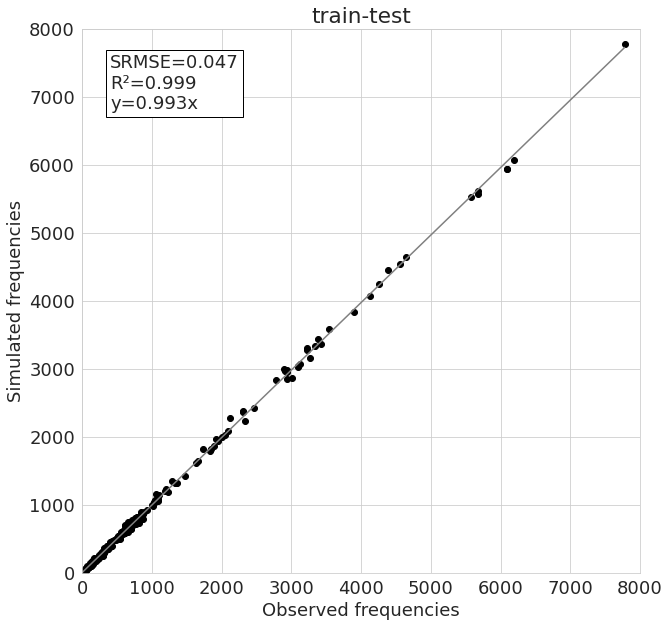

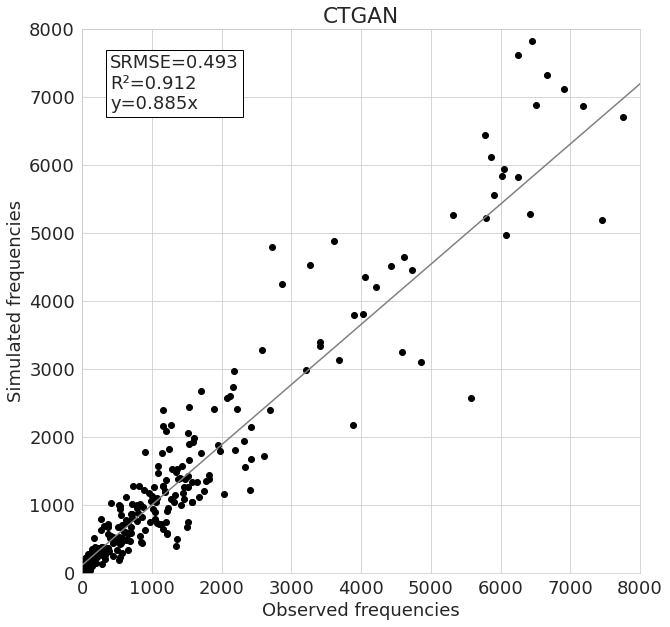

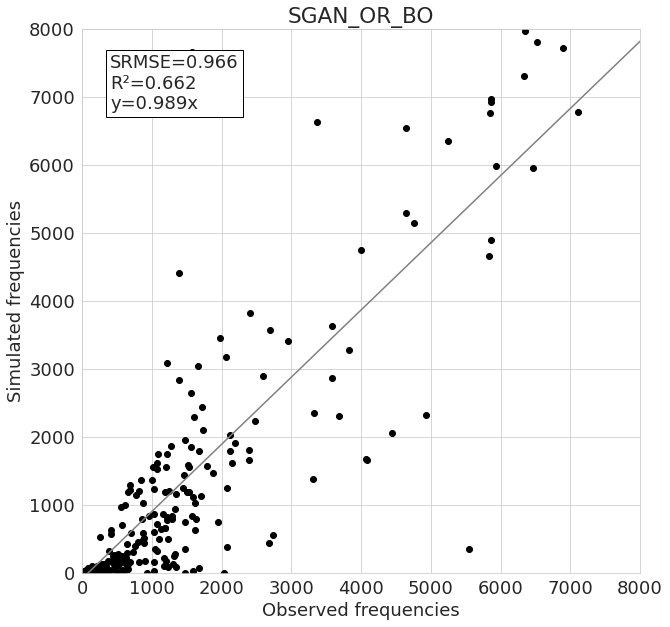

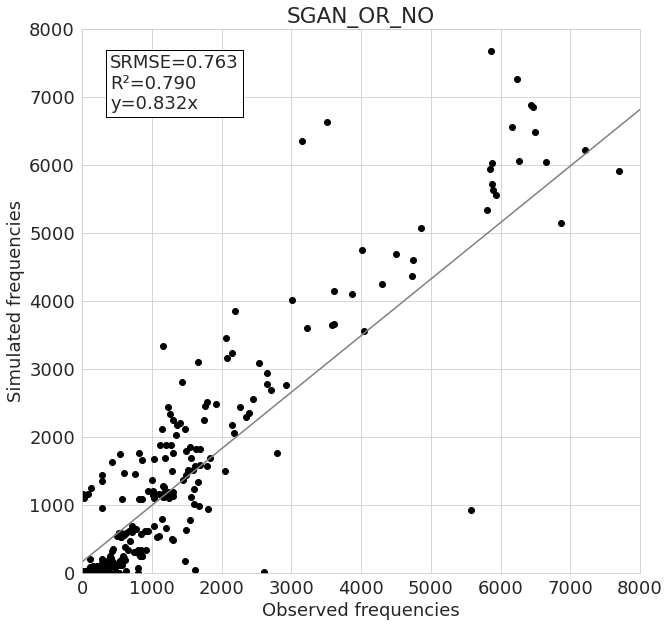

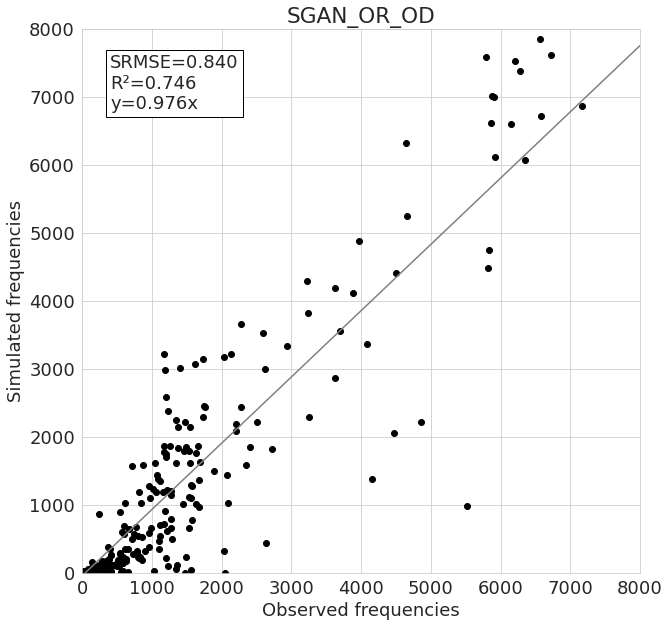

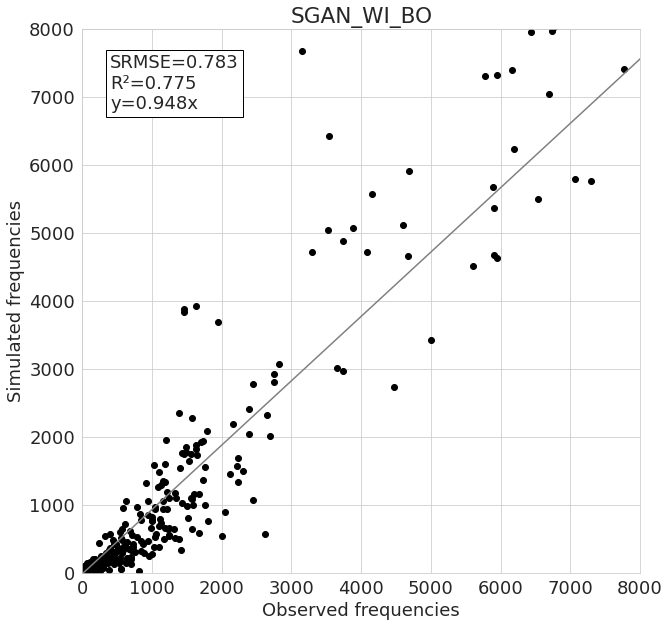

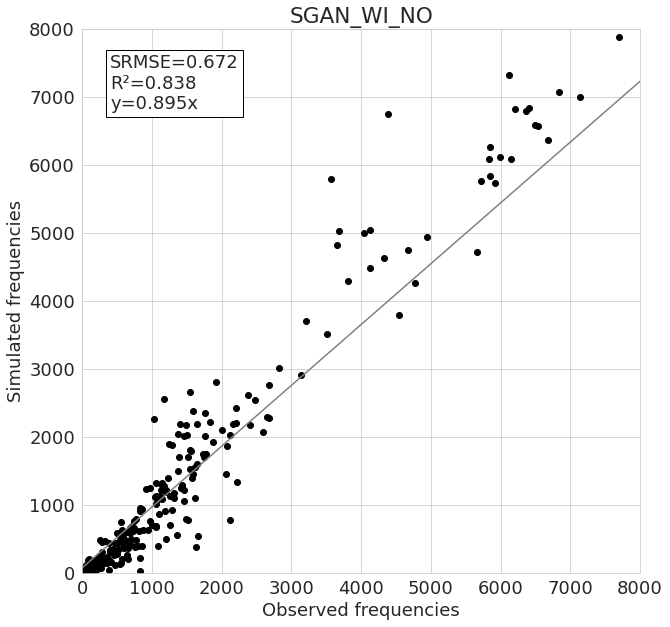

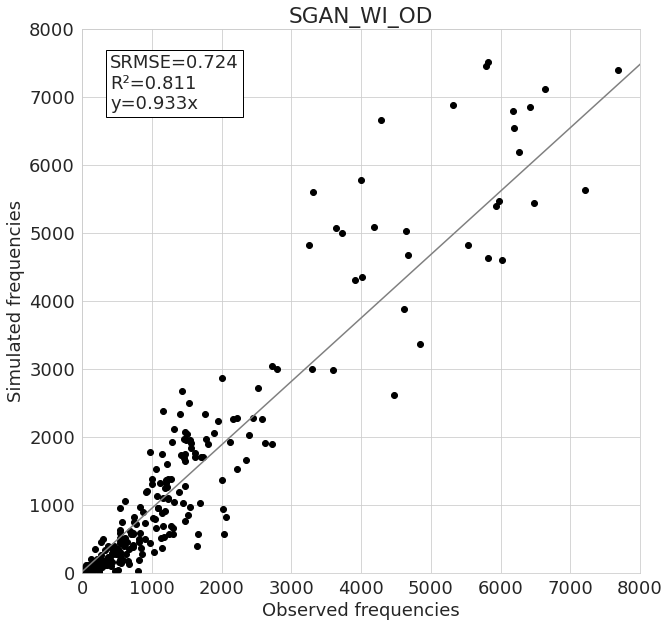

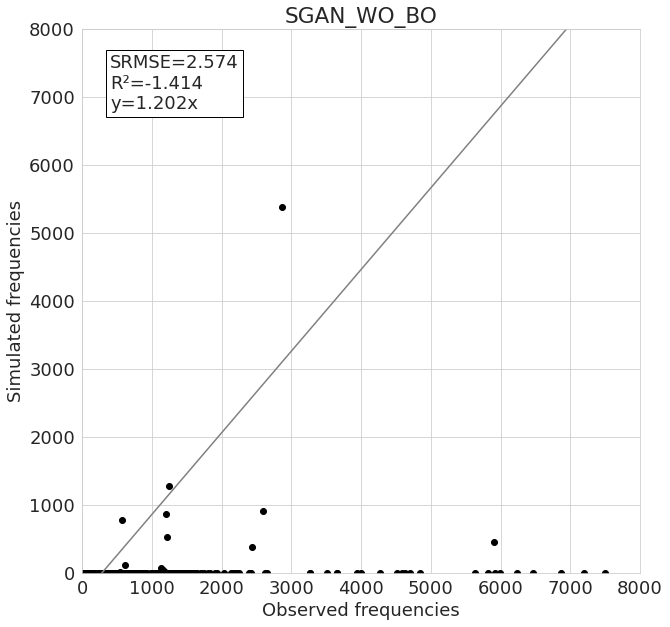

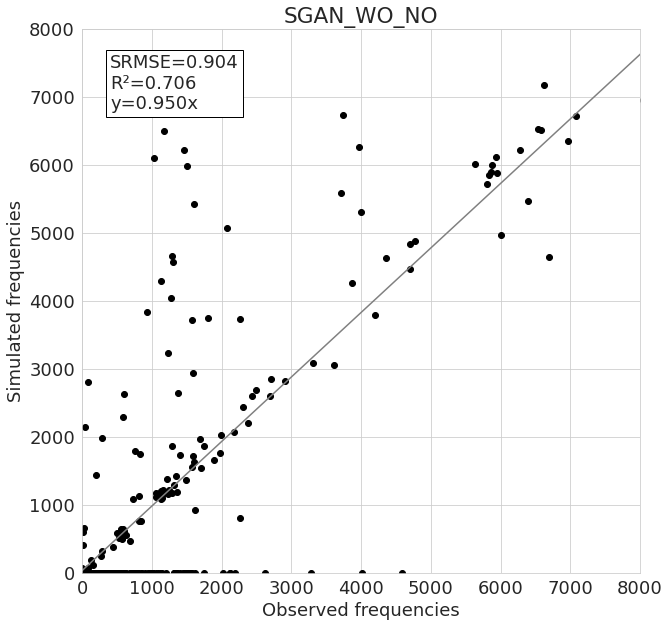

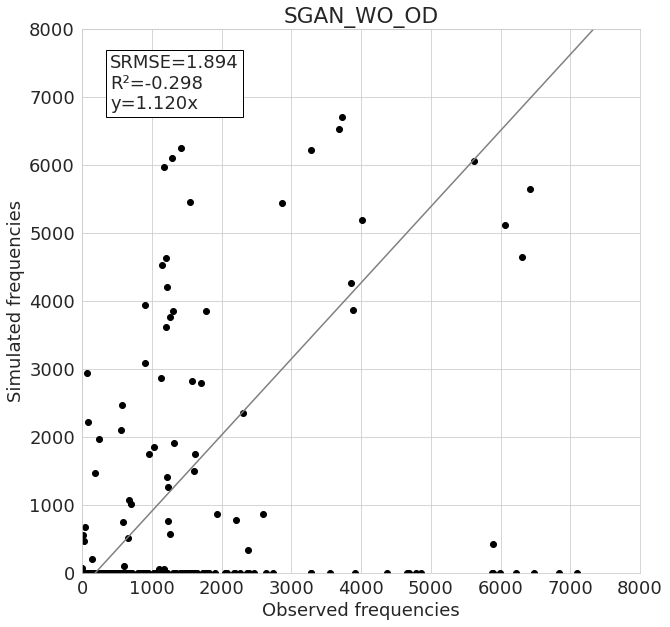

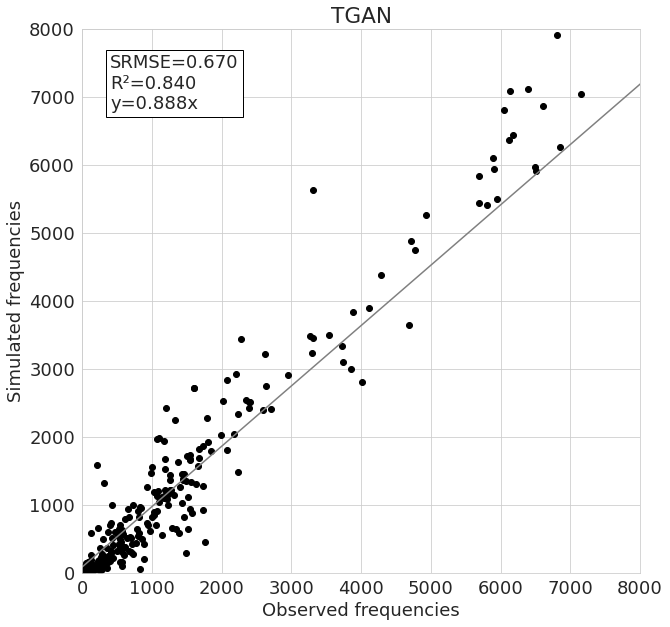

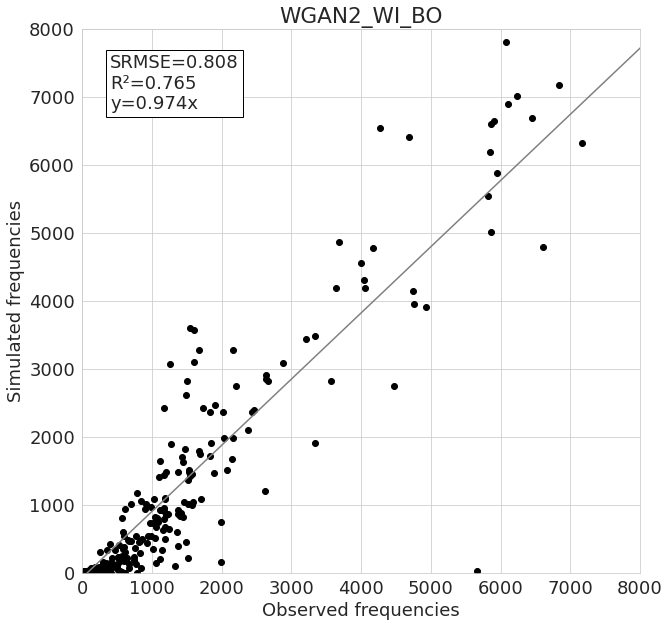

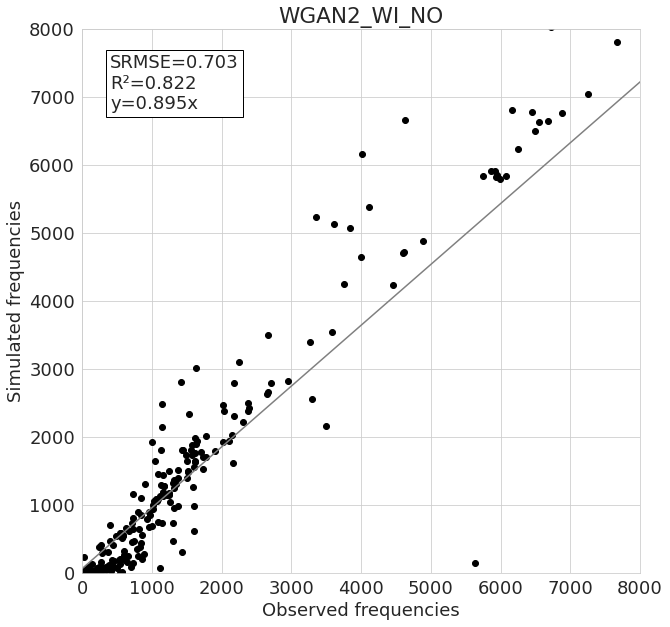

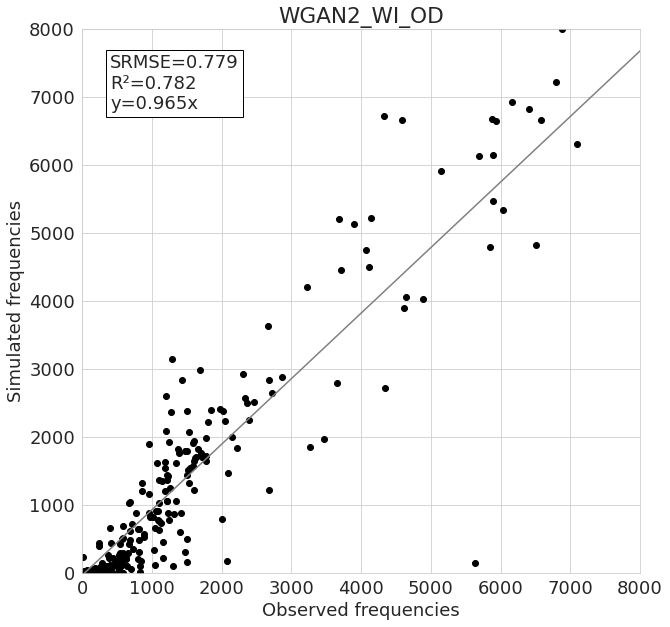

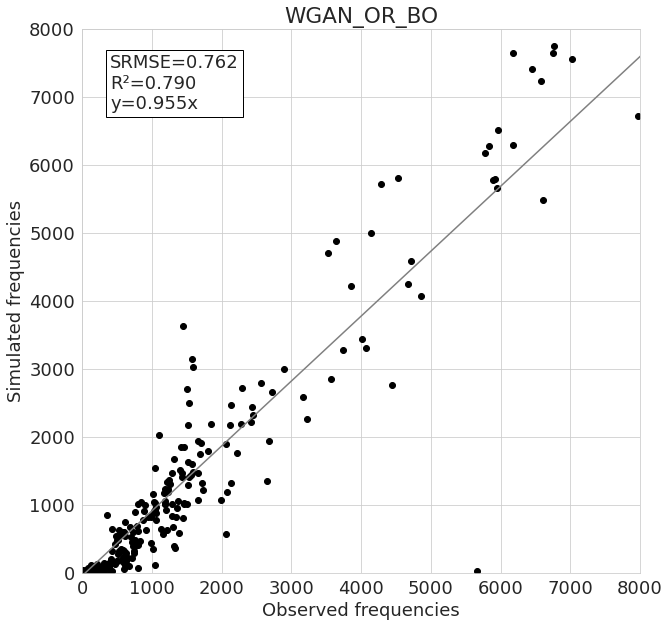

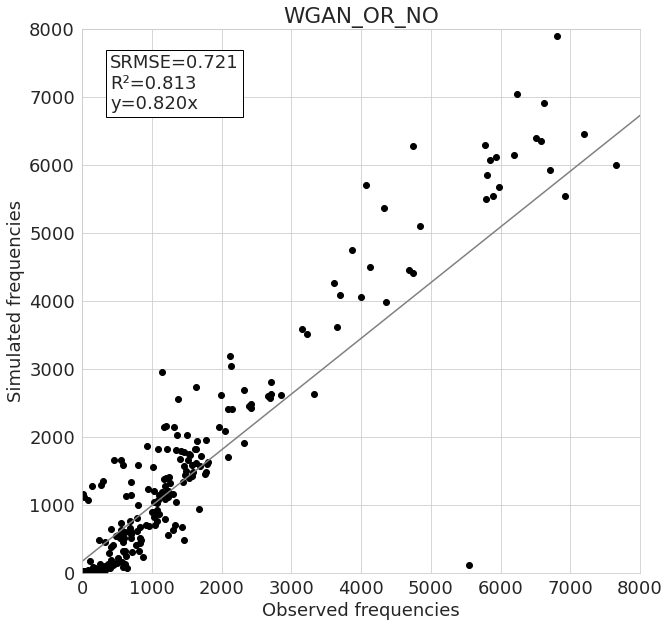

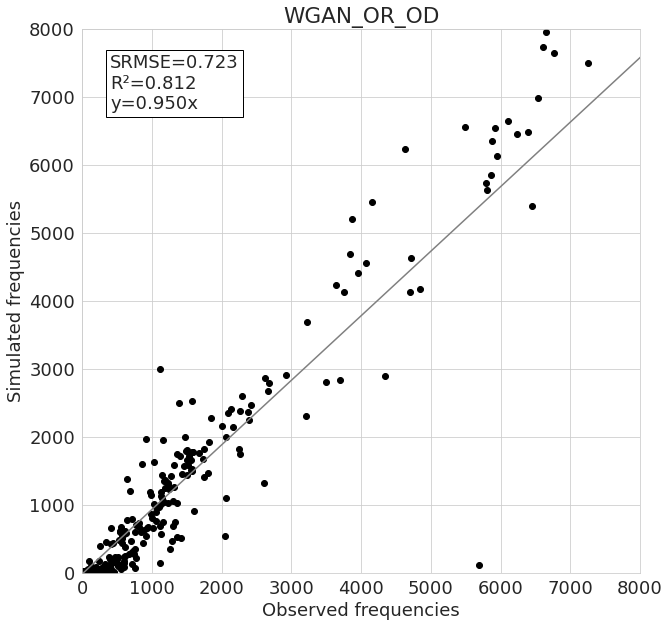

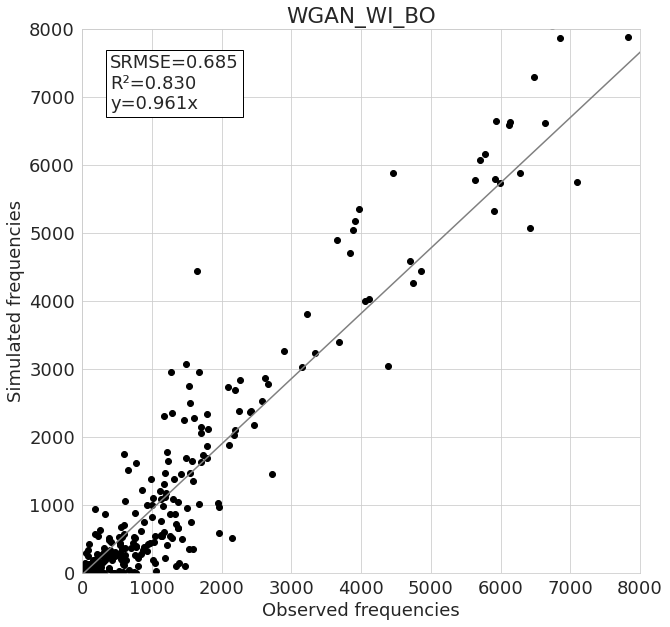

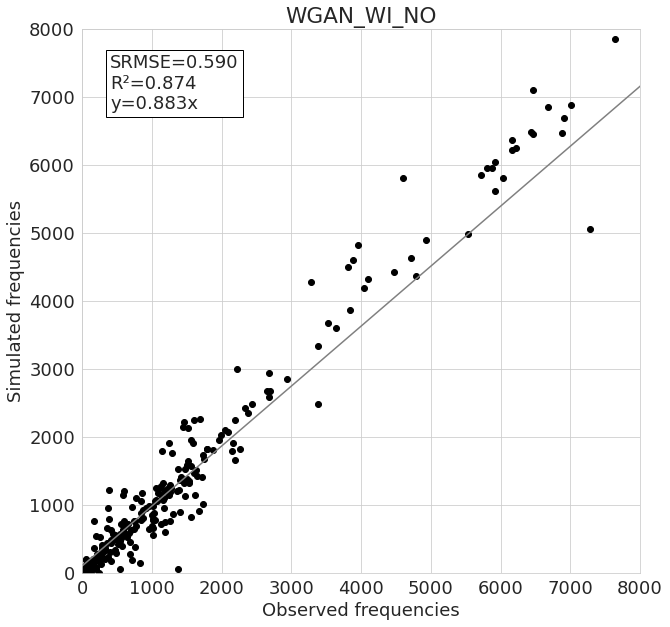

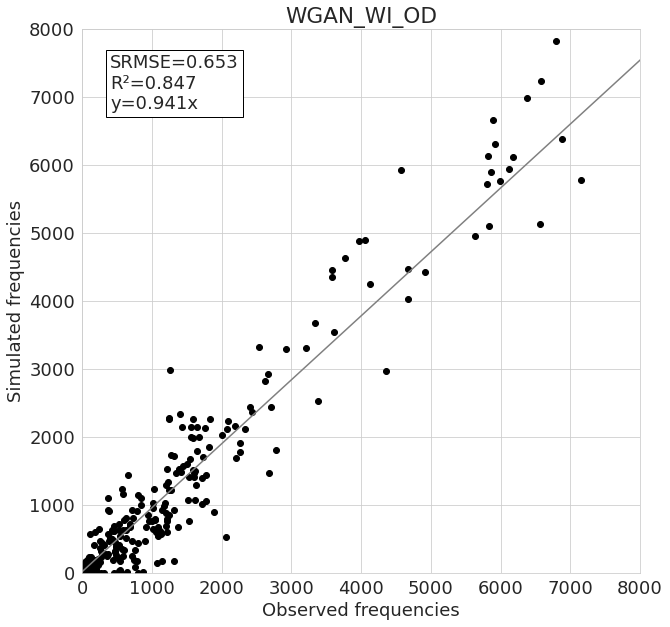

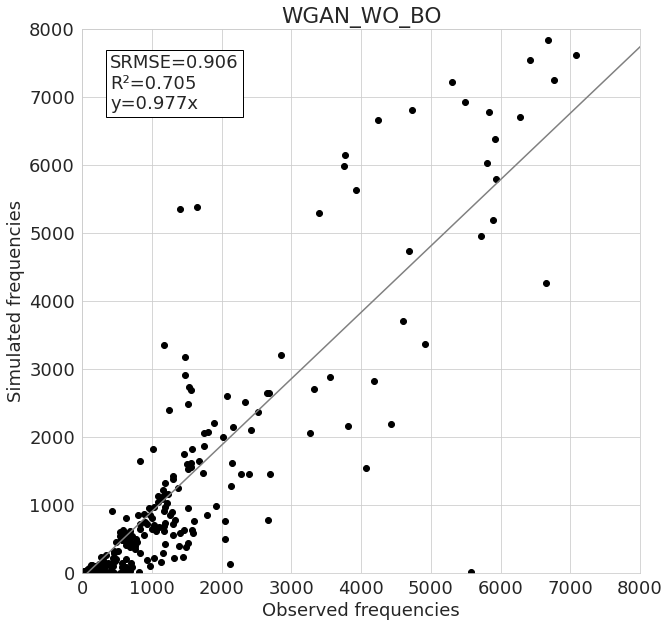

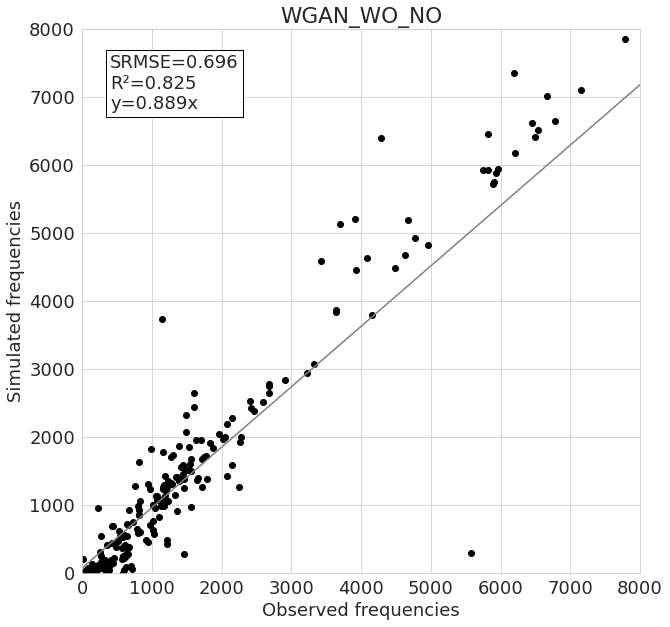

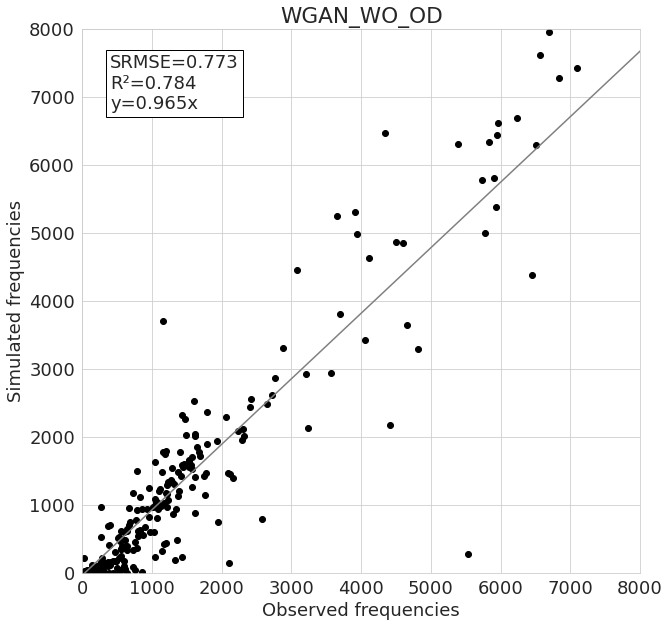

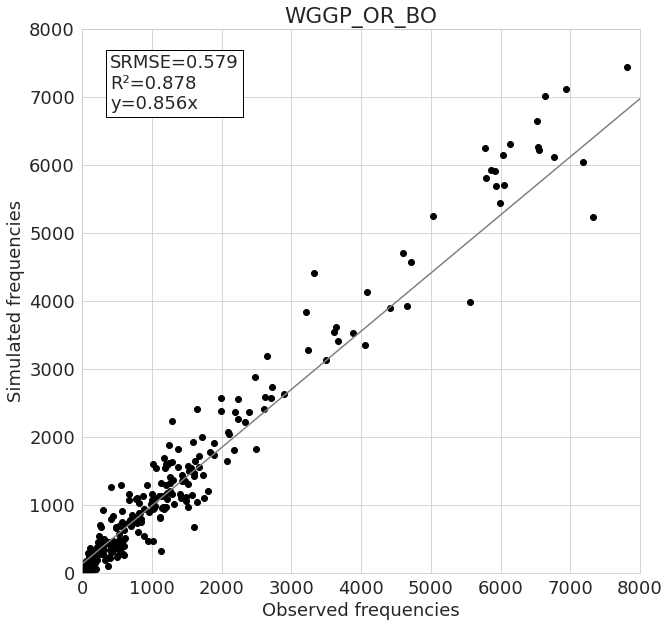

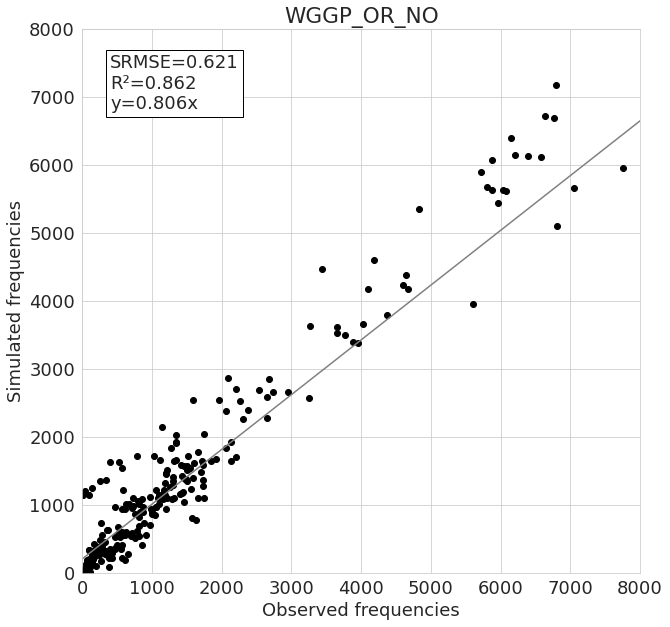

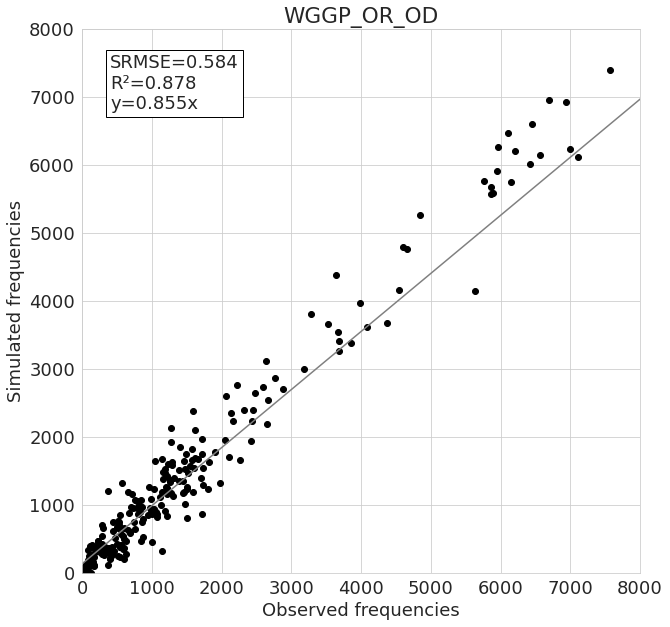

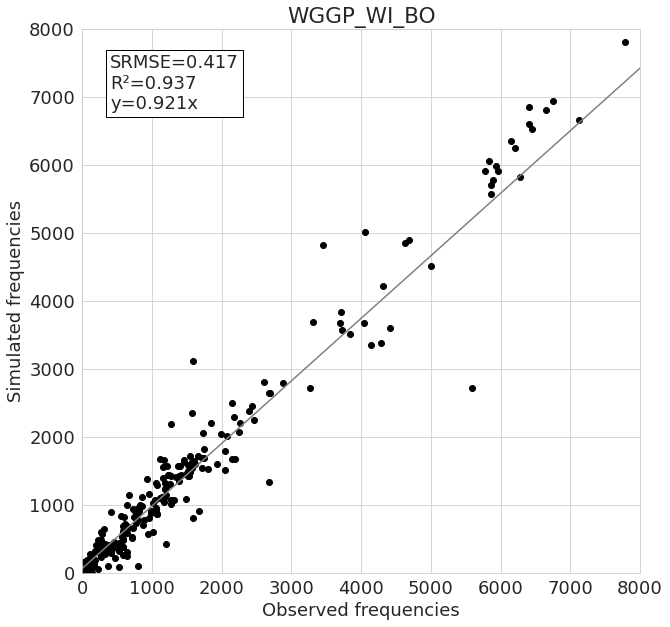

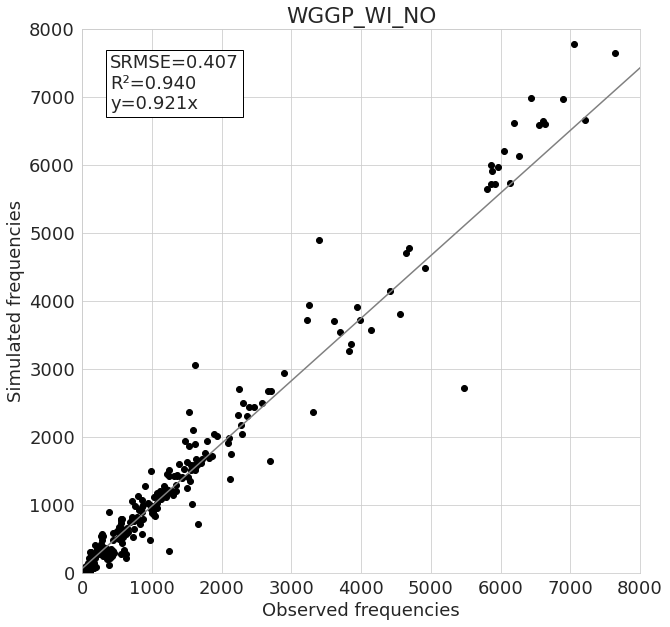

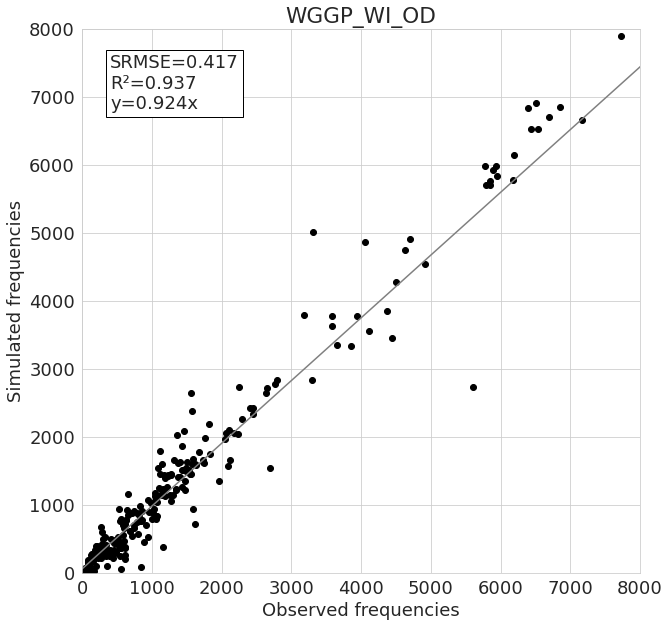

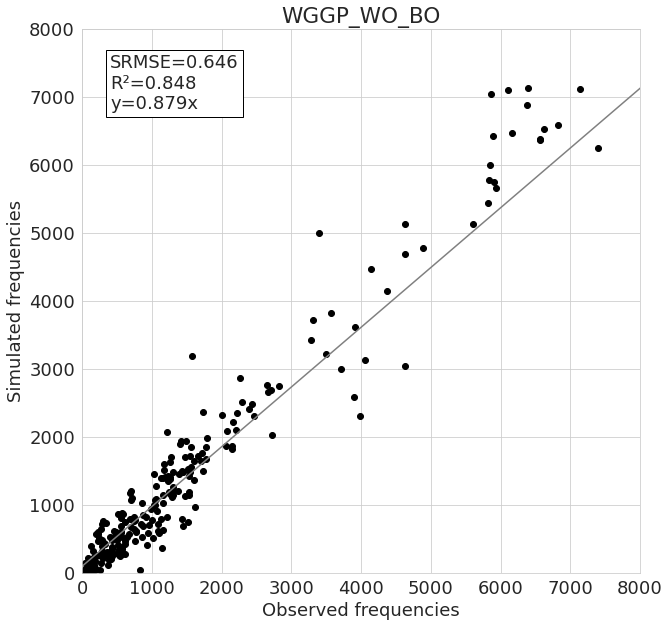

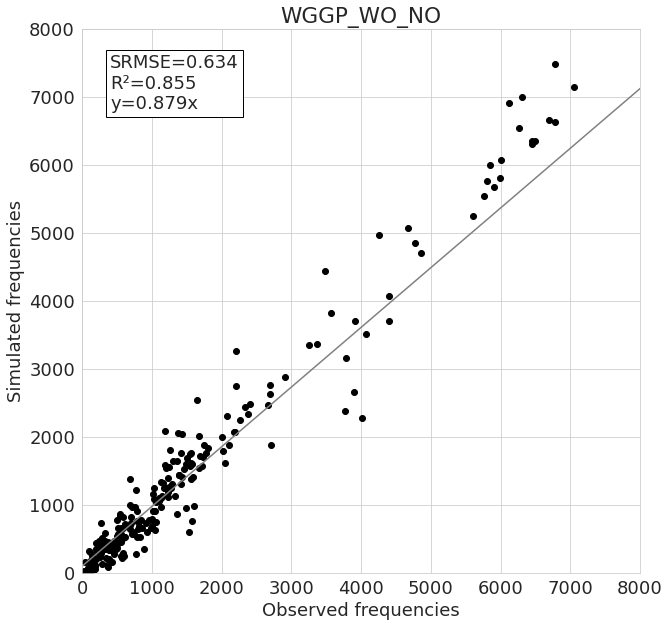

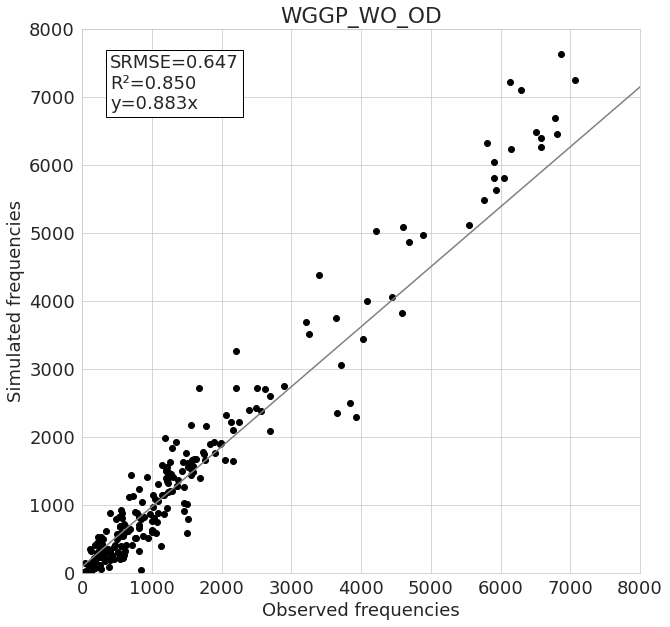

In [27]:
plot(train_freqs, test_freqs, 'train-test')#, '../figures/' + dataset + '/' + labels[i+1])
for i in range(len(synth_freqs)):
    plot(orig_freqs[i], synth_freqs[i], labels[i+1])#, '../figures/' + dataset + '/' + labels[i+1])

# Rankings

In [28]:
# possible values: 'mae', 'rmse', 'r2', 'srmse', 'corr'
str_ = 'srmse'

dct = {}
for i in range(len(synth_freqs)):
    stat = stats(orig_freqs[i], synth_freqs[i])
    dct[labels[i+1]] = stat[str_]

stat = stats(train_freqs, test_freqs)
dct['random-split'] = stat[str_]
    
if str_ in ['r2', 'corr']:
    sorted_dct = {k: v for k, v in sorted(dct.items(), key=lambda item: item[1])[::-1]}
else:
    sorted_dct = {k: v for k, v in sorted(dct.items(), key=lambda item: item[1])}

print('Ranking based on {}'.format(str_.upper()))
for i, item in enumerate(sorted_dct):
    print('  {:>2}. {:<25} - {:.3f}'.format(i+1, item, sorted_dct[item]))

Ranking based on SRMSE
   1. random-split              - 0.047
   2. WGGP_WI_NO                - 0.407
   3. WGGP_WI_OD                - 0.417
   4. WGGP_WI_BO                - 0.417
   5. CTGAN                     - 0.493
   6. WGGP_OR_BO                - 0.579
   7. WGGP_OR_OD                - 0.584
   8. WGAN_WI_NO                - 0.590
   9. WGGP_OR_NO                - 0.621
  10. WGGP_WO_NO                - 0.634
  11. WGGP_WO_BO                - 0.646
  12. WGGP_WO_OD                - 0.647
  13. WGAN_WI_OD                - 0.653
  14. TGAN                      - 0.670
  15. SGAN_WI_NO                - 0.672
  16. WGAN_WI_BO                - 0.685
  17. WGAN_WO_NO                - 0.696
  18. WGAN2_WI_NO               - 0.703
  19. WGAN_OR_NO                - 0.721
  20. WGAN_OR_OD                - 0.723
  21. SGAN_WI_OD                - 0.724
  22. WGAN_OR_BO                - 0.762
  23. SGAN_OR_NO                - 0.763
  24. WGAN_WO_OD                - 0.773
  25. WGAN2_WI_OD

# More details

In [29]:
stats_vals = []

for i in range(len(dfs)-1):
    stats_vals.append({'mae': [], 'rmse': [], 'r2': [], 'srmse': [], 'corr': []})

for c in dfs[0].columns:
    for i in range(1, len(dfs)):
        
        [a,b],bins = get_frequency_list(dfs[0][c], dfs[i][c], 50)
        
        stat = stats(a,b)
        
        for k in stat.keys():
            stats_vals[i-1][k].append(stat[k])
            
n = len(stats_vals)

msk = []
for i in dfs[0].columns:
    if i in continuous_cols:
        msk.append(True)
    else:
        msk.append(False)
msk = np.array(msk)

D:\Users\glede\anaconda3\envs\py37\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Users\glede\anaconda3\envs\py37\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [30]:
stat = 'srmse'

print("Weighted average of {} (continuous / categorical)".format(stat.upper()))
for i in range(n):
    print("  {:<25}: {:.3f} +- {:.3f} ({:.3f} +- {:.3f} / {:.3f} +- {:.3f})".format(
        labels[i+1], 
        np.mean(np.array(stats_vals[i]['srmse'])),
        np.std(np.array(stats_vals[i]['srmse'])),
        np.mean(np.array(stats_vals[i]['srmse'])[msk]), 
        np.std(np.array(stats_vals[i]['srmse'])[msk]), 
        np.mean(np.array(stats_vals[i]['srmse'])[~msk]), 
        np.std(np.array(stats_vals[i]['srmse'])[~msk])))

Weighted average of SRMSE (continuous / categorical)
  CTGAN                    : 0.519 +- 0.719 (0.893 +- 0.907 / 0.195 +- 0.164)
  SGAN_OR_BO               : 1.205 +- 1.257 (2.227 +- 1.180 / 0.320 +- 0.229)
  SGAN_OR_NO               : 0.862 +- 1.187 (1.661 +- 1.348 / 0.169 +- 0.150)
  SGAN_OR_OD               : 0.941 +- 1.148 (1.663 +- 1.344 / 0.316 +- 0.230)
  SGAN_WI_BO               : 1.009 +- 1.214 (1.933 +- 1.251 / 0.208 +- 0.117)
  SGAN_WI_NO               : 0.688 +- 1.170 (1.425 +- 1.391 / 0.050 +- 0.033)
  SGAN_WI_OD               : 0.779 +- 1.126 (1.435 +- 1.382 / 0.211 +- 0.118)
  SGAN_WO_BO               : 3.577 +- 2.512 (5.988 +- 1.300 / 1.489 +- 0.958)
  SGAN_WO_NO               : 1.352 +- 1.521 (2.862 +- 0.850 / 0.043 +- 0.040)
  SGAN_WO_OD               : 2.127 +- 1.138 (2.864 +- 0.847 / 1.488 +- 0.957)
  TGAN                     : 0.645 +- 1.168 (1.316 +- 1.447 / 0.063 +- 0.058)
  WGAN2_WI_BO              : 0.918 +- 1.181 (1.677 +- 1.375 / 0.260 +- 0.183)
  WGAN2_WI_

In [31]:
for i, c in enumerate(dfs[0].columns):
    print("{}: {:.3f} vs {:.3f}".format(c, stats_vals[3]['srmse'][i], stats_vals[0]['srmse'][i]))

travel_mode: 0.230 vs 0.091
purpose: 0.704 vs 0.243
fueltype: 0.415 vs 0.161
faretype: 0.238 vs 0.078
bus_scale: 0.092 vs 0.105
survey_year: 0.181 vs 0.086
travel_year: 0.197 vs 0.059
travel_month: 0.363 vs 0.427
travel_date: 0.881 vs 0.607
day_of_week: 0.223 vs 0.457
start_time_linear: 1.102 vs 0.475
age: 0.539 vs 0.212
female: 0.054 vs 0.098
driving_license: 0.047 vs 0.161
car_ownership: 0.324 vs 0.220
distance: 1.842 vs 0.691
dur_walking: 0.673 vs 0.509
dur_cycling: 0.622 vs 0.347
dur_pt_access: 2.406 vs 0.625
dur_pt_rail: 4.265 vs 1.469
dur_pt_bus: 1.308 vs 0.865
dur_pt_int: 4.770 vs 3.771
pt_n_interchanges: 0.556 vs 0.065
dur_driving: 0.780 vs 0.517
cost_transit: 1.914 vs 1.325
cost_driving_fuel: 0.696 vs 0.592
cost_driving_con_charge: 0.233 vs 0.062
driving_traffic_percent: 0.702 vs 0.216


In [32]:
tmp = {}
tmp['continuous'] = []
tmp['categorical'] = []
stat = 'srmse'

names = ['CTGAN', 'WGAN_WI_NO']
list_ = []
for n in names:
    list_.append(labels.index(n))

for j, m in enumerate(list_):
    tmp['continuous'].append([])
    tmp['categorical'].append([])
    for i, c in enumerate(dfs[0].columns):
        name = 'continuous' if c in continuous_cols else 'categorical'
        tmp[name][j].append(stats_vals[m-1]['srmse'][i])

Text(0, 0.5, 'SRMSE')

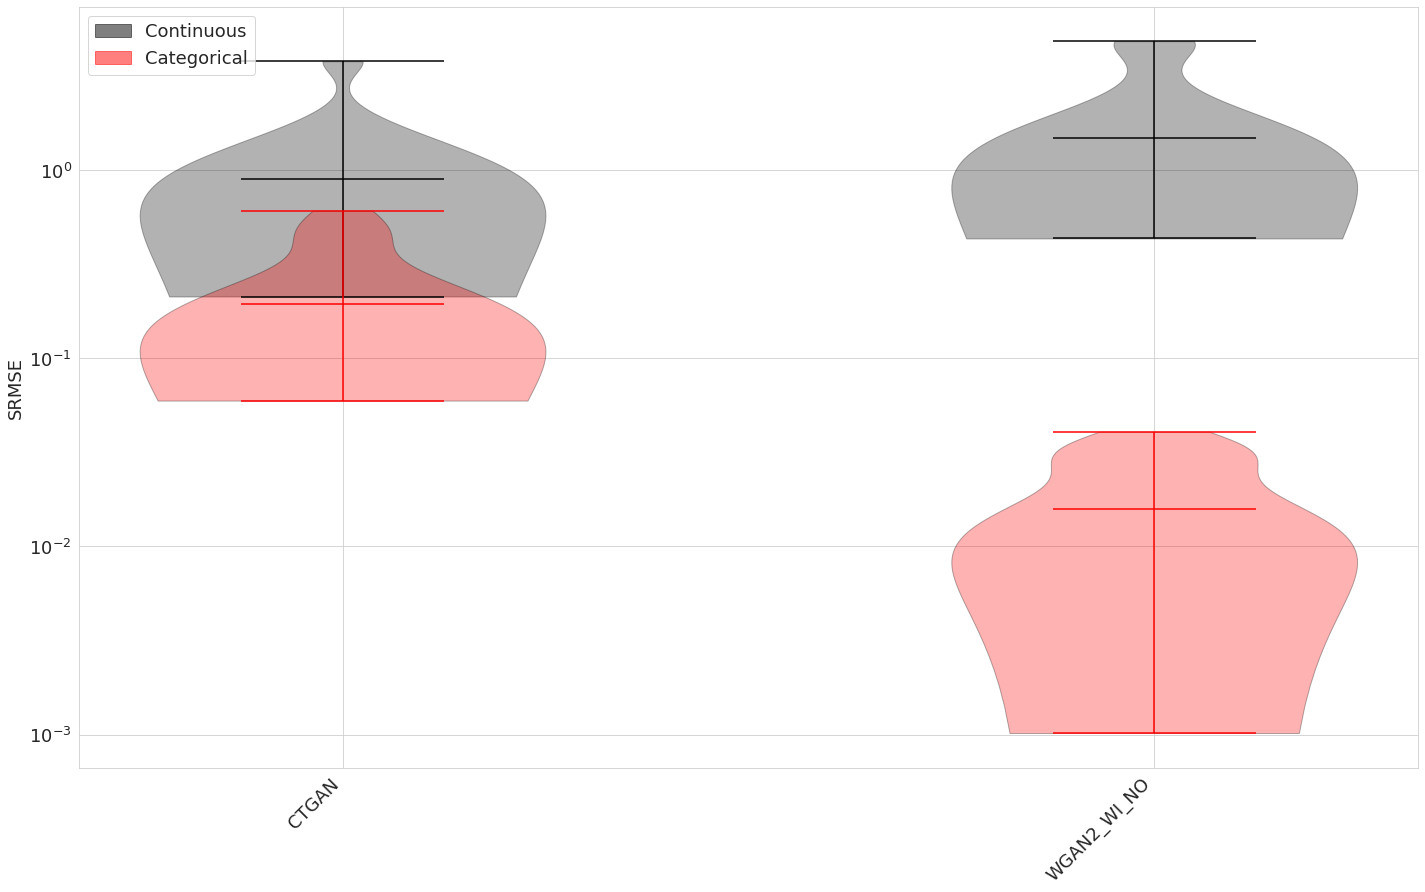

In [33]:
plt.figure(figsize=(24,14), facecolor='white')
parts = plt.violinplot(tmp['continuous'], np.arange(len(list_)), showmeans=True)

for pc in parts['bodies']:
    pc.set_facecolor('black')
    pc.set_edgecolor('black')

parts['cbars'].set_edgecolor('black')
parts['cmaxes'].set_edgecolor('black')
parts['cmins'].set_edgecolor('black')
parts['cmeans'].set_edgecolor('black')

parts = plt.violinplot(tmp['categorical'], np.arange(len(list_)), showmeans=True)

for pc in parts['bodies']:
    pc.set_facecolor('red')
    pc.set_edgecolor('black')

parts['cbars'].set_edgecolor('red')
parts['cmaxes'].set_edgecolor('red')
parts['cmins'].set_edgecolor('red')
parts['cmeans'].set_edgecolor('red')

plt.yscale('log')

# 'fake' invisible object
black_patch = mpatches.Patch(color='black', alpha=0.5)
red_patch = mpatches.Patch(color='red', alpha=0.5)
label = ['Continuous', 'Categorical']

fake_handles = [black_patch, red_patch]
plt.legend(fake_handles, label, loc=2)


plt.xticks(np.arange(len(list_)), np.array(labels)[list_], rotation=45, ha='right')
plt.ylabel(stat.upper())